<a href="https://colab.research.google.com/github/smartsinovich/Stepik_NeuralNetworks_and_ComputerVision/blob/master/Stepik_seminar_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Модернизация сети LeNet

![alt text](https://camo.githubusercontent.com/d464ca86de08d7173fcccc38ec0c840a6da02cea/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e65745f4f726967696e616c5f496d6167652e6a7067)

![alt text](https://camo.githubusercontent.com/9028f39092178a1b65f243eb8b471ebd84920cec/68747470733a2f2f656e676d726b2e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031382f30392f4c654e45745f53756d6d6172795f5461626c652e6a7067)

Что мы исправим:


*   Сейчас не используют активацию tanh (и сигмоиды), она приводит к затуханию градиента
*   Вместо свертки 5*5 (25 параметров) используем каскад из двух сверток 3*3 (2*9=18 параметров)


*   Вместо Average Pooling (который сейчас используют только в конце сети) будем использовать MaxPooling
*   Применим батч-нормализацию





In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [0]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

0it [00:00, ?it/s]

9920512it [00:02, 3391594.64it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 56541.09it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 949271.27it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 20949.90it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
len(y_train), len(y_test)

(60000, 10000)

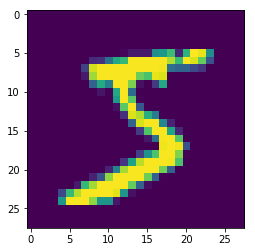

tensor(5)


In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [0]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Будем менять ф-ю активации, пуллинг, размер свертки, -/+ батч-нормализация



1.   tahn -> relu
2.   слой 5 * 5 -> два слоя 3 * 3
3.  average pooling -> max pooling
4. добавляем батч-нормализацию после 2 слоев свертки





In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 #вводим переменные, которые определяют ф-ю актиации и пуллинг
                 #а также размер свертки и использование/не использование батч-нормализации
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        #слой батч-нормализации
        #картинки - BatchNorm2d, вектора - BatchNorm1d
        #параметр - кол-во каналов, которое имеет картинка/вектор перед батч-нормализацией
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        #если размер свертки 5 - одна свертка
        #если размер свертки 3 - две последовательные свертки
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        #если хотим батч-нормализацию, то после свертки дополнительно применяем слой батч-нормализации
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

Теперь мы можем запускать трейн с разными параметрами и смотреть на результаты работы разных сетей

In [0]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            #флажки нужны для батч-нормализации
            #нужно для корректного изменения среднего значения и станд отклонения 
            
            #сеть находится в состоянии тренировки            
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
        #сеть находится в состоянии evaluation
        #средн значение и станд отклонение не изменяются
        #иначе обученная сеть может перестать работать
        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}


accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.9777)
tensor(0.9853)
tensor(0.9853)
tensor(0.9875)
tensor(0.9878)
tensor(0.9860)
tensor(0.9872)
tensor(0.9889)
tensor(0.9868)
tensor(0.9869)
tensor(0.9879)
tensor(0.9890)
tensor(0.9898)
tensor(0.9885)
tensor(0.9886)
tensor(0.9873)
tensor(0.9887)
tensor(0.9870)
tensor(0.9880)
tensor(0.9881)
tensor(0.9879)
tensor(0.9865)
tensor(0.9892)
tensor(0.9882)
tensor(0.9873)
tensor(0.9873)
tensor(0.9881)
tensor(0.9863)
tensor(0.9885)
tensor(0.9898)
---------------
tensor(0.9802)
tensor(0.9887)
tensor(0.9890)
tensor(0.9889)
tensor(0.9900)
tensor(0.9907)
tensor(0.9890)
tensor(0.9924)
tensor(0.9903)
tensor(0.9897)
tensor(0.9894)
tensor(0.9903)
tensor(0.9845)
tensor(0.9906)
tensor(0.9898)
tensor(0.9869)
tensor(0.9889)
tensor(0.9902)
tensor(0.9898)
tensor(0.9907)
tensor(0.9908)
tensor(0.9918)
tensor(0.9898)
tensor(0.9901)
tensor(0.9919)
tensor(0.9902)
tensor(0.9895)
tensor(0.9897)
tensor(0.9906)
tensor(0.9903)
---------------
tensor(0.9817)
tensor(0.9873)
tensor(0.9883)
tensor(0.9879)
tensor(0

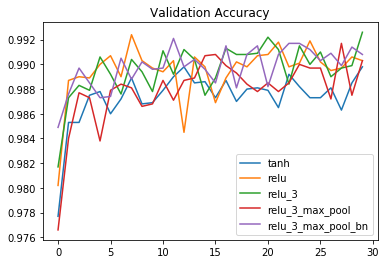

In [0]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

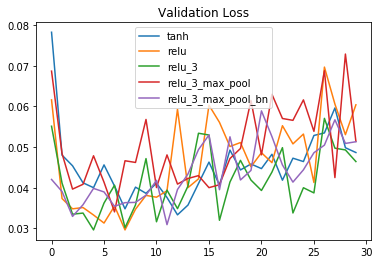

In [0]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

Результаты:

30 эпох обучения

*   все гарфики доходят примерно до одинакового результата точности на валидации
*   гарфик точности не очень показательный
* график relu 3 на лоссе показывает самые хорошие рез-ты
* после 10-й эпохи происходит переобучение - все лоссы растут 
* изменили свертку с 5 на 5 на две по 3 на 3
, сеть меньше переобучается
* макспуллинги ухудшают обучение- результаты не всегда интуитивны
* батч-нормализация не ускоряет обучение, возможно, потому, что датасет простой и сеть его быстро и так выучивает
*italicized text*

